In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Define a list of tickers
tickers = ['RELIANCE.NS', 'ITC.NS', 'LT.NS', 'HDFCBANK.NS']

# Define start and end dates for data download
start_date = '2020-01-01'
end_date = '2023-03-13'

# Download stock data for each ticker
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

# Combine adjusted close prices into a single dataframe
prices = pd.concat([data[ticker]['Adj Close'] for ticker in tickers], axis=1, keys=tickers)
prices.columns = prices.columns.get_level_values(0)

# Print the first 5 rows of the prices dataframe
print(prices.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            RELIANCE.NS      ITC.NS        LT.NS  HDFCBANK.NS
Date                                                         
2020-01-01  1480.595825  202.353333  1226.583862  1258.457886
2020-01-02  1505.802124  203.840607  1259.684326  1266.479614
2020-01-03  1507.616577  202.693283  1250.086670  1248.418579
2020-01-06  1472.651367  199.803726  1232.951172  1221.401001
2020-01-07  1495.307617  200.016205  1236.462646  1240.741455


,RELIANCE.NS,ITC.NS,LT.NS,HDFCBANK.NS,Port
Date,,,,,
2023-03-10,1.56876,1.917438,1.759236,1.262378,1.719983


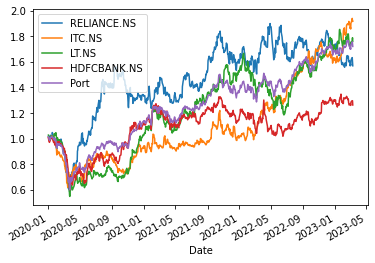

In [3]:
# Change the dataframe to percentage change and create a column for the equally weighted portfolio. 
# Plot the normalized stock prices for comparison.

df = prices.pct_change().dropna()
df['Port'] = df.mean(axis=1)
(df+1).cumprod().plot()

(df+1).cumprod()[-1:]

<Axes: >

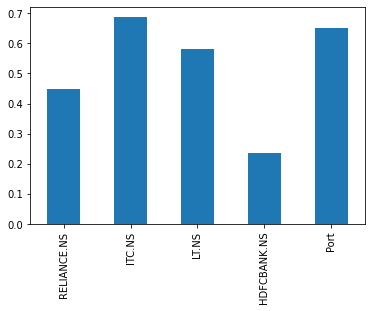

In [4]:
# Calculate Sharpe Ratio
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf =0.05 #5% risk free rate
sharpes = df.apply(sharpe_ratio, args=(N,rf,),axis=0)

sharpes.plot.bar()

Text(0, 0.5, 'Sortino Ratio')

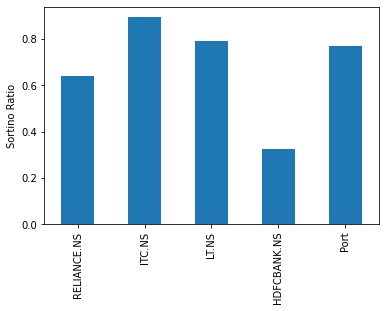

In [5]:
# Calculate Sortino ratio
def sortino_ratio(series, N,rf):
    mean = series.mean() * N -rf
    std_neg = series[series<0].std()*np.sqrt(N)
    return mean/std_neg


sortinos = df.apply(sortino_ratio, args=(N,rf,), axis=0 )
sortinos.plot.bar()
plt.ylabel('Sortino Ratio')

Text(0, 0.5, 'Max Drawdown')

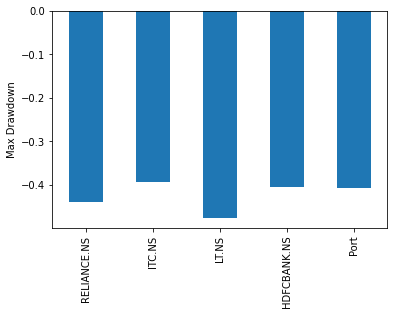

In [6]:
#max drawdown for the stocks listed above
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()


max_drawdowns = df.apply(max_drawdown,axis=0)
max_drawdowns.plot.bar()
plt.ylabel('Max Drawdown')

Text(0, 0.5, 'Calmar ratio')

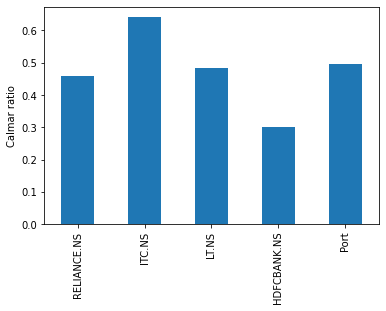

In [7]:
# Calculate Calmar ratio
calmars = df.mean()*255/abs(max_drawdowns)
calmars.plot.bar()
plt.ylabel('Calmar ratio')

In [8]:
# Combine all the ratios we have calculated and put them in a pandas dataframe.
btstats = pd.DataFrame()
btstats['sortino'] = sortinos
btstats['sharpe'] = sharpes
btstats['maxdd'] = max_drawdowns
btstats['calmar'] = calmars

btstats

,sortino,sharpe,maxdd,calmar
RELIANCE.NS,0.638445,0.447489,-0.440829,0.459172
ITC.NS,0.894158,0.687027,-0.394656,0.641524
LT.NS,0.790465,0.580604,-0.476125,0.482454
HDFCBANK.NS,0.324591,0.234830,-0.404653,0.302406
Port,0.768394,0.649399,-0.407494,0.495514


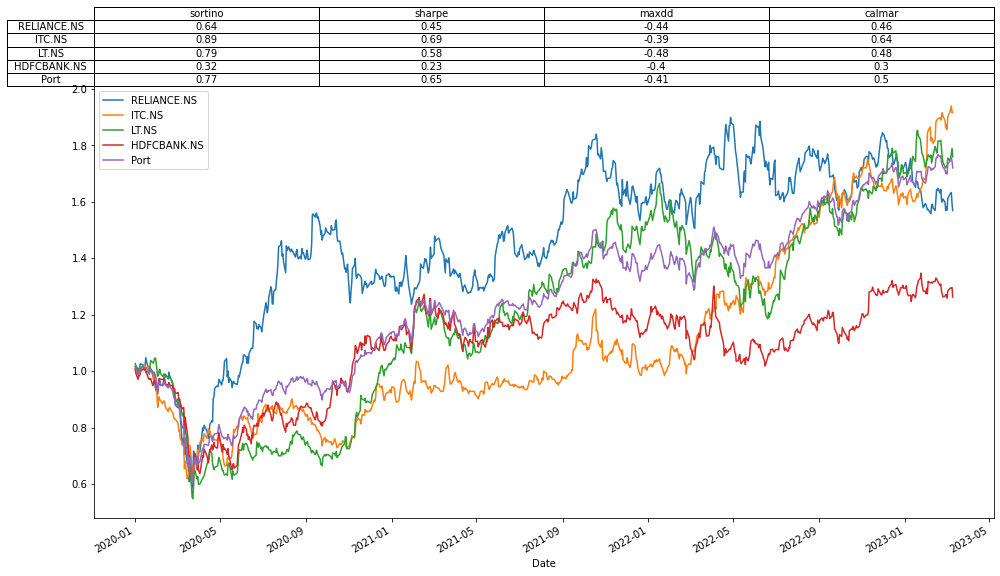

In [9]:
# Plot dataframe as a table

(df+1).cumprod().plot(figsize=(14,8))
plt.table(cellText=np.round(btstats.values,2), colLabels=btstats.columns,
          rowLabels=btstats.index,rowLoc='center',cellLoc='center',loc='top',
          colWidths=[0.25]*len(btstats.columns))
plt.tight_layout()